In [2]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd, seaborn as sns

prj_dir = '/ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/badran/'

import sys, os
sys.path.append(prj_dir + 'src/')
import _config, _lib

results_dir = prj_dir + 'results/example_trajectories/'
# os.makedirs(results_dir)

## plotting funcs

In [3]:
def sim_trajectories(gts_to_fitness, spikeins, gt_to_start, num_timepoints, noise = 0.005):
    '''
        Simulate trajectories.
        Output:
        - Full length genotype matrix over time
        - Marginal (single mutations) matrix over time
        -- Requires all genotypes to be the same length
    '''
    fitnesses = np.array(list(gts_to_fitness.values()))
    all_fqs = []
    gts = list(gts_to_fitness.keys())
    curr_fqs = np.array(list(gt_to_start.values()))
    for t in range(num_timepoints):
        all_fqs.append(curr_fqs)
        mean_fitness = np.dot(fitnesses, curr_fqs)
        changes = fitnesses / mean_fitness
        curr_fqs = changes * curr_fqs
        
        # drift (for plot legibility)
        drift_fqs = np.random.normal(curr_fqs, scale = noise)
        drift_fqs = [d_fq if c_fq > 0 else 0 for d_fq, c_fq in zip(drift_fqs, curr_fqs) ]
        drift_fqs = np.minimum(drift_fqs, 1)
        drift_fqs = np.maximum(drift_fqs, 0)
        
        curr_fqs = drift_fqs / sum(drift_fqs)

        # spike ins
        for sit in spikeins:
            if sit == t:
                (si_gt, si_fq) = spikeins[sit]
                gt_idx = gts.index(si_gt)
                
                reduce_factor = 1 - si_fq
                curr_fqs = curr_fqs * reduce_factor
                curr_fqs[gt_idx] = si_fq
        
        
    gt_df = pd.DataFrame(np.array(all_fqs).T, index = list(gts_to_fitness.keys()))
    gt_df *= 100
    
    gts = list(gts_to_fitness.keys())
    gt_len = len(gts[0])
    
    import copy
    om_df = copy.copy(gt_df)
    alphabet = dict()
    for gt_idx in range(gt_len):
        nts = [s[gt_idx] for s in gts]
        om_df[f'nt {gt_idx}'] = nts
        alphabet[gt_idx] = set(nts)
    
    from collections import defaultdict
    om_dd = defaultdict(list)
    for t in range(num_timepoints):
        for gt_idx in range(gt_len):
            for nt in alphabet[gt_idx]:
                om_dd['Time'].append(t)
#                 om_dd['Position'].append(gt_idx)
#                 om_dd['Nucleotide'].append(nt)
                om_dd['Nucleotide and position'].append(f'{nt} {gt_idx}')
                
                fq = sum(om_df[om_df[f'nt {gt_idx}'] == nt][t])
                om_dd['Frequency (%)'].append(fq)
    om_df = pd.DataFrame(om_dd)
    
    # Reshape gt_df
    gt_df['Genotype'] = gt_df.index
    gt_df = gt_df.melt(id_vars = 'Genotype', var_name = 'Time', value_name = 'Frequency (%)')
    
    return {
        'gt_df': gt_df,
        'om_df': om_df,
    }

test_package = sim_trajectories(
    # Fitness
    {
        '--': 1,
        'a-': 2,
        '-b': 2,
        'ab': 5,
    },
    # Spike ins
    {
        4: ('ab', 0.05),
    }, 
    # Starting fqs
    {
        '--': 0.9,
        'a-': 0.05,
        '-b': 0.05,
        'ab': 0,
    },
    # Num. timepoints
    12,
    noise = 0.004,
)



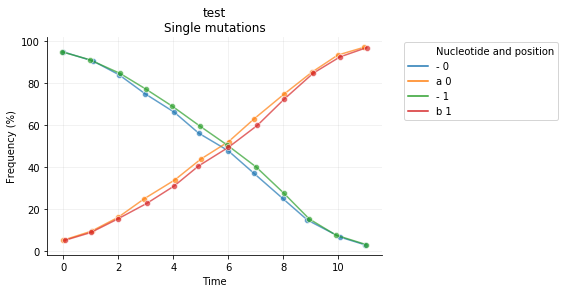

In [4]:
def plot_marginals(om_df, plot_nm = ''):

    lines = sorted(list(set(om_df['Nucleotide and position'])))
    # colors = sns.color_palette('hls', int(len(lines) * 1.2))
    # palette = {gt: color for gt, color in zip(lines, colors)}

    time_jitter = 0.05
    om_df['Time'] = np.random.normal(list(om_df['Time']), scale = time_jitter)
    
    sns.lineplot(
        x = 'Time',
        y = 'Frequency (%)',
        hue = 'Nucleotide and position',
        marker = 'o',
        alpha = 0.7,
    #     palette = palette,
    #     palette = sns.color_palette('husl', len(lines)),
        data = om_df,
    )
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left');
    plt.grid(alpha = 0.2)
    sns.despine()
    
    plt.title(f'{plot_nm}\nSingle mutations')
    
    plt.show()
    plt.close()
    return
    
plot_marginals(test_package['om_df'], 'test')

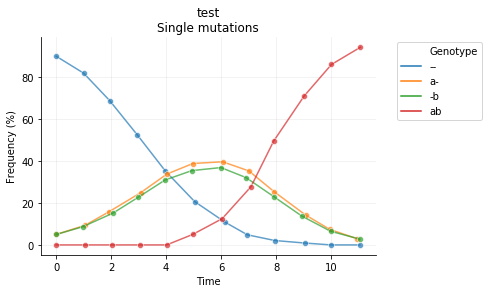

In [5]:
 def plot_full(gt_df, plot_nm = ''):

    time_jitter = 0.05
    gt_df['Time'] = np.random.normal(list(gt_df['Time']), scale = time_jitter)
        
    sns.lineplot(
        x = 'Time',
        y = 'Frequency (%)',
        hue = 'Genotype',
        marker = 'o',
        alpha = 0.7,
        data = gt_df,
    )
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left');
    plt.grid(alpha = 0.2)
    sns.despine()
    
    plt.title(f'{plot_nm}\nSingle mutations')
    
    plt.show()
    plt.close()
    return
    
plot_full(test_package['gt_df'], 'test')

In [6]:
def save_simulation(package, exp_short_nm):
#     out_dir = '/ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/badran/out/pb_e2_dataset_multi/'
    
#     om_df = package['om_df']
#     import copy
#     dfs = copy.copy(om_df)
#     dfs['Frequency (%)'] /= 100
#     pv_df = dfs.pivot(index = 'Nucleotide and position', columns = 'Time', values = 'Frequency (%)')
# #     pv_df['Nucleotide and position'] = pv_df.index
#     pv_df.to_csv(out_dir + f'obs_reads_pivot_{exp_short_nm}.csv')

#     groups = [[0], [1]]
#     import pickle
#     with open(out_dir + f'read_groups_{exp_short_nm}.pkl', 'wb') as f:
#         pickle.dump(groups, f)
    
    
#     proposed_genotypes = ['--', 'a-', '-b', 'ab']
#     with open(out_dir + f'propose_genotypes_{exp_short_nm}.txt', 'w') as f:
#         for gt in proposed_genotypes:
#             f.write(f'{gt}\n')
    
    pass
    
    return

## make plots

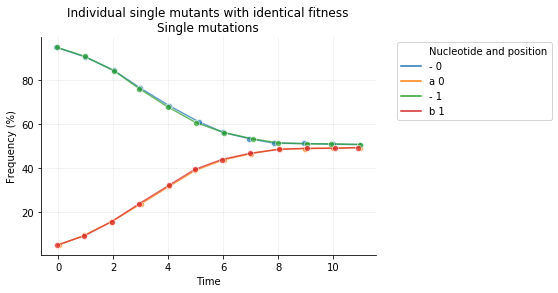

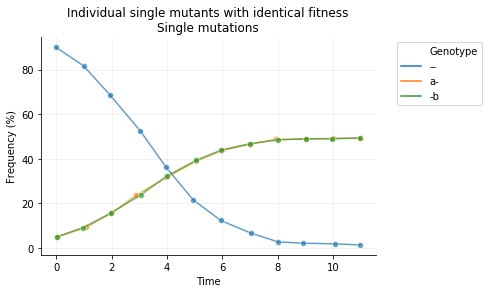

In [7]:
exp_nm = 'Individual single mutants with identical fitness'

package = sim_trajectories(
    # Fitness
    {
        '--': 1,
        'a-': 2,
        '-b': 2,
    },
    # Spike ins
    '', 
    # Starting fractions
    {
        '--': 0.9,
        'a-': 0.05,
        '-b': 0.05,
    },
    # Num timepoints
    12,
    noise = 0.004,
)
save_simulation(package, f'extraj_singles')

plot_marginals(package['om_df'], exp_nm)
plot_full(package['gt_df'], exp_nm)



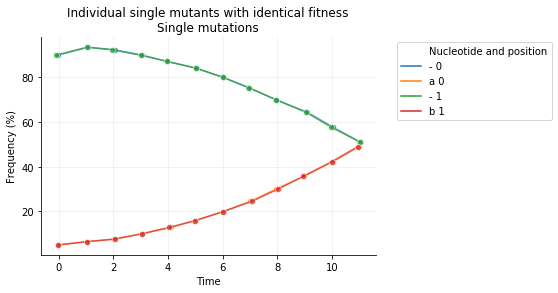

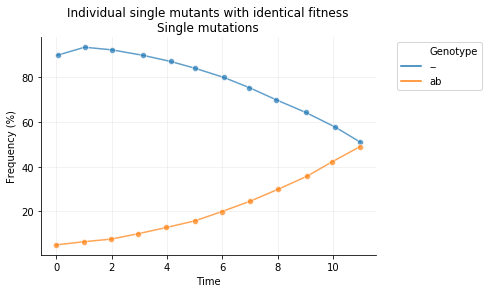

In [27]:
exp_nm = 'Individual single mutants with identical fitness'

package = sim_trajectories(
    # Fitness
    {
        '--': 1,
        'ab': 1.3,
    },
    # Spike ins
    '', 
    # Starting fractions
    {
        '--': 0.9,
        'ab': 0.05,
    },
    # Num timepoints
    12,
    noise = 0.004,
)
# save_simulation(package, f'extraj_singles')

plot_marginals(package['om_df'], exp_nm)
plot_full(package['gt_df'], exp_nm)



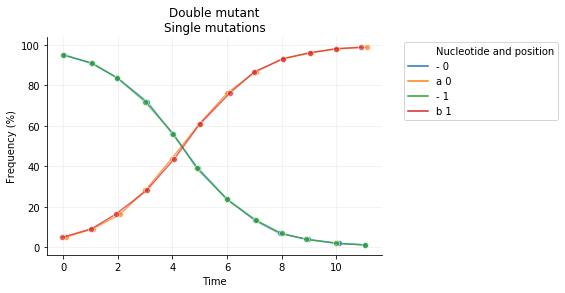

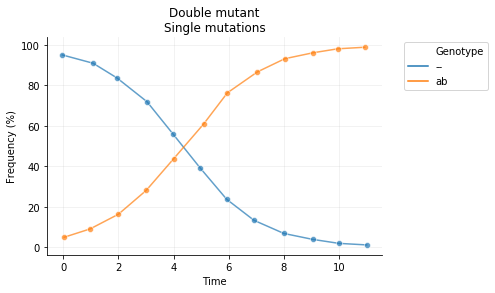

In [8]:
exp_nm = 'Double mutant'

package = sim_trajectories(
    # Fitness
    {
        '--': 1,
        'ab': 2,
    },
    # Spike ins
    '', 
    # Starting fractions
    {
        '--': 0.95,
        'ab': 0.05,
    },
    # Num timepoints
    12,
    noise = 0.004,
)
save_simulation(package, f'extraj_double')

plot_marginals(package['om_df'], exp_nm)
plot_full(package['gt_df'], exp_nm)

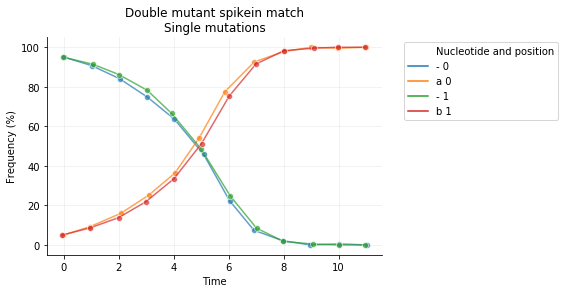

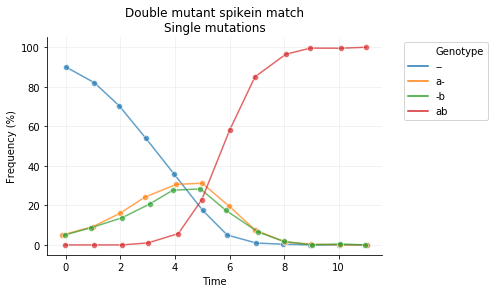

In [21]:
exp_nm = 'Double mutant spikein match'

package = sim_trajectories(
        # Fitness
    {
        '--': 1,
        'a-': 2,
        '-b': 2,
        'ab': 8,
    },
    # Spike ins
    {
        2: ('ab', 0.01),
    }, 
    # Starting fqs
    {
        '--': 0.9,
        'a-': 0.05,
        '-b': 0.05,
        'ab': 0,
    },
    # Num timepoints
    12,
#     noise = 0.004,
)
# save_simulation(package, f'extraj_double_spikein')

plot_marginals(package['om_df'], exp_nm)
plot_full(package['gt_df'], exp_nm)

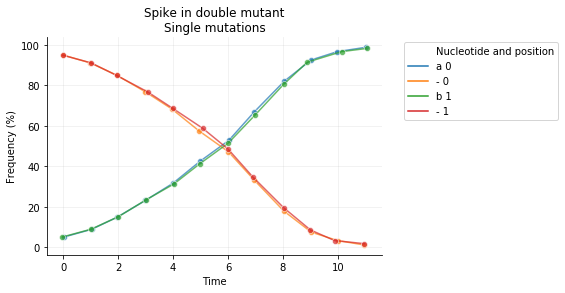

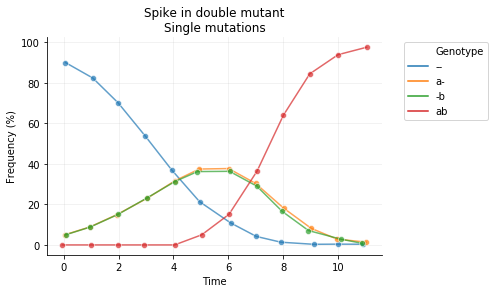

In [196]:
exp_nm = 'Spike in double mutant'

package = sim_trajectories(
        # Fitness
    {
        '--': 1,
        'a-': 2,
        '-b': 2,
        'ab': 6,
    },
    # Spike ins
    {
        4: ('ab', 0.05),
    }, 
    # Starting fqs
    {
        '--': 0.9,
        'a-': 0.05,
        '-b': 0.05,
        'ab': 0,
    },
    # Num timepoints
    12,
    noise = 0.004,
)
save_simulation(package, f'extraj_double_spikein')

plot_marginals(package['om_df'], exp_nm)
plot_full(package['gt_df'], exp_nm)

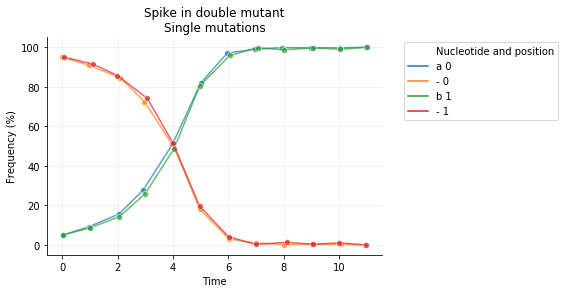

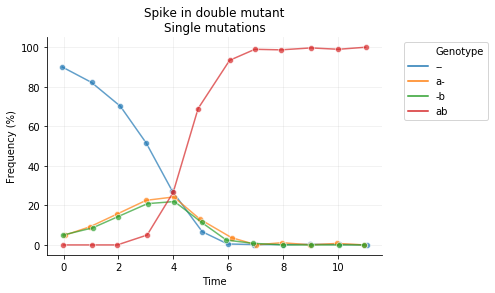

In [200]:
exp_nm = 'Spike in double mutant'

package = sim_trajectories(
        # Fitness
    {
        '--': 1,
        'a-': 2,
        '-b': 2,
        'ab': 10,
    },
    # Spike ins
    {
        2: ('ab', 0.05),
    }, 
    # Starting fqs
    {
        '--': 0.9,
        'a-': 0.05,
        '-b': 0.05,
        'ab': 0,
    },
    # Num timepoints
    12,
    noise = 0.004,
)
save_simulation(package, f'extraj_double_spikein2')

plot_marginals(package['om_df'], exp_nm)
plot_full(package['gt_df'], exp_nm)

## temp

In [22]:
package['om_df']

,Time,Nucleotide and position,Frequency (%)
0,0.004161,- 0,95.000000
1,-0.016566,a 0,5.000000
2,-0.027531,- 1,95.000000
3,-0.060184,b 1,5.000000
4,1.008986,- 0,90.711022
5,0.959790,a 0,9.288978
6,1.063425,- 1,91.354666
7,0.958467,b 1,8.645334
8,2.025522,- 0,84.095907
9,2.060356,a 0,15.904093
